In [131]:
import numpy as np
import pandas as pd
import os

from pycausal.pycausal import pycausal as pc

import random
import re
import copy

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score



In [132]:
attr_names = (
    "checking_status",
    "duration",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_status",
    "employment",
    "installment_commitment",
    "personal_status",
    "other_parties",
    "residence_since",
    "property_magnitude",
    "age",
    "other_payment_plans",
    "housing",
    "existing_credits",
    "job",
    "num_dependents",
    "own_telephone",
    "foreign_worker",
    "class"
)



# df = pandas.read_table('./german.data-numeric.txt', delim_whitespace=True)

In [133]:

def find_range_cols(data):
    range_col = [] # columns that fit numerical values into ranges
    for col in data.select_dtypes(exclude=['int']).columns:
        if any(item in data[col][0] for item in ['>', '<']): 
            range_col.append(col)
                
    return range_col

class DataEncoder(object):
    def __init__(self, class_column='class', cat_columns=None):
        self.class_column = class_column
        self.cat_columns = cat_columns

        # these will be trained with fit_encoders()
        self.column_encoders = {} # label encoder
        self.cat_encoder = None # one-hot encoder
        self.label_encoder = None # label encoder

    def fit(self, data):
        """
        Fit one-hot encoders for categorical features and an integer encoder for
        the label. These can be used later to transform raw data into a form
        that ATM can work with.

        data: pd.DataFrame of unprocessed data
        """
        if self.class_column not in data.columns:
            raise KeyError('Class column "%s" not found in dataset!' %
                           self.class_column)
            
        range_col = find_range_cols(data)
                
        self.range_col = range_col
            

        # encode categorical columns, leave ordinal values alone
        if self.cat_columns is None:
            cats = data.drop([self.class_column]+range_col, axis=1).select_dtypes(exclude=['int'])
            self.cat_columns = cats.columns
        else:
            cats = data[self.cat_columns].drop(range_col, axis=1).select_dtypes(exclude=['int'])
            
        self.cat_cols = cats.columns
        
        for cat_name in cats.columns:   
        # save the indices of categorical columns for one-hot encoding

            # encode each feature as an integer in range(unique_vals)
            le = LabelEncoder()
            cats[cat_name] = le.fit_transform(cats[cat_name])
            self.column_encoders[cat_name] = le

        # One-hot encode the whole feature matrix.
        # Set sparse to False so that we can test for NaNs in the output
        self.cat_encoder = OneHotEncoder(categories='auto',sparse=False)
        self.cat_encoder.fit(cats)

        # Train an encoder for the label as well
        labels = np.array(data[[self.class_column]])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)
        

    def transform(self, data):
        """
        Convert a DataFrame of labeled data to a feature matrix in the form
        that ATM can use.
        """
        y = self.transform_y(data)
        X = self.transform_x(data)

        return X, y
    
    def transform_x(self, data):
        """
        only transform x, for the generated data
        """
        cats = data[self.cat_columns]

        # encode each categorical feature as an integer
        for column, encoder in list(self.column_encoders.items()):
            cats[column] = encoder.transform(cats[column])

        # one-hot encode the categorical features
        X = self.cat_encoder.transform(cats)
        
        if self.class_column in data:
            nums = data.drop([self.class_column], axis=1).select_dtypes(include=['int']).values
        else:
            nums = data.select_dtypes(include=['int']).values
            
       
        # transform range cols into integrate. e.g., <4 -> 1; 4<x<7 -> 2
        ranges = []
        for col in self.range_col:
            values = data[col]
            ranges.append( self.range2int(values) )
        ranges = np.transpose( np.array(ranges) )
#         print(X.shape, nums.shape, ranges.shape)
        
        X = np.concatenate((X, nums, ranges), axis=1)
        
        return X
    
    def transform_y(self, data):
        if self.class_column in data:
            # pull labels into a separate series and transform them to integers
            labels = np.array(data[[self.class_column]])
            y = self.label_encoder.transform(labels)
            # drop the label column and transform the remaining features
        else:
            y = None
            
        return y
    
    def range2int(self, values):
        ranges = []
        for v in values:
            if v not in ranges:
                ranges.append(v)
        
        def sort_key(x):
            num_strings = re.findall('\d+', x)
            # 'undefined' is in the front
            if len(num_strings)==0:
                return -1
            # x> 1, x<7
            elif len(num_strings)==1:
                return int(num_strings[0])*2
            # 1<x<7
            else:
                nums = map(int, num_strings) # string to number
                return sum(nums)
                
        ranges.sort(key=sort_key)
        return list(map(lambda x: ranges.index(x), values))
        
        
    
    def fit_transform(self, data):
        """ Process data into a form that ATM can use. """
        self.fit(data)
        return self.transform(data)

In [134]:

data = pd.read_csv('./credit_clean.csv')

# drop rows with any NA values
data = data.dropna(how='any')

encoder = DataEncoder()
encoder.fit(data)
x_train, y_train = encoder.transform(data)
        


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
svm_cls = SVC(
    C = 0.0484055070919,
    cache_size = 15000,
    class_weight = "balanced",
    gamma = 424.665365448,
    kernel = "rbf",
    max_iter = 50000,
    probability = True,
    shrinking = True)


mlp_cls = MLPClassifier(
    activation = "relu",
    alpha = 0.00146693288878,
    batch_size = "auto",
    hidden_layer_sizes= (189,50, ),
    learning_rate = "constant",
    learning_rate_init = 0.898892816545,
    solver = "sgd"
)

rf_cls = RandomForestClassifier(
    bootstrap=True, 
    class_weight=None, 
    criterion='entropy', 
    max_depth=10, 
    max_features=0.45, 
    max_leaf_nodes=None, 
    min_impurity_decrease=1e-07, 
    min_samples_leaf=6, 
    min_samples_split=7, 
    min_weight_fraction_leaf=0.0, 
    n_estimators=512, 
    n_jobs=1, 
    oob_score=False, 
    random_state=3, 
    verbose=0, 
    warm_start=False
)

knn_cls = KNeighborsClassifier(
    algorithm = "ball_tree",
    leaf_size = 40,
    metric = "manhattan",
    n_neighbors = 17
)



In [136]:
# svm_score = cross_val_score(svm_cls, x_train, y_train, scoring='accuracy', cv=10) 
# mlp_score = cross_val_score(mlp_cls, x_train, y_train, scoring='accuracy', cv=10) 

knn_cls.fit(x_train, y_train)
knn_score = cross_val_score(knn_cls, x_train, y_train, scoring='accuracy', cv=10) 

rf_cls.fit(x_train, y_train)
rf_score = cross_val_score(rf_cls, x_train, y_train, scoring='accuracy', cv=10) 

print('knn', knn_score, 'rf', rf_score)


knn [0.74 0.71 0.72 0.76 0.76 0.74 0.67 0.74 0.75 0.71] rf [0.83 0.71 0.72 0.77 0.77 0.8  0.71 0.81 0.75 0.77]


In [137]:
# Data generator
class DataGene(object):
    
    def __init__(self, data, sample_num=10, class_col='class'):
        self.data = data
        self.sample_num = sample_num
        self.class_col = 'class'
        
    def get_samples(self):
        features = self.data.drop([self.class_col], axis=1)
        range_cols = find_range_cols(self.data)
        cat_cols = features.select_dtypes(exclude=['int']).drop(range_cols, axis=1).columns
        num_cols = features.select_dtypes(include=['int']).columns
        
        samples = []
        
        for i in range(self.sample_num):
            sample_cat = [
                random.choice(encoder.column_encoders[cat_name].classes_)
                for cat_name in cat_cols
            ]
            sample_num = [
                random.choice( list(set(features[num_name])) )
                for num_name in num_cols
            ]
            sample_range = [
                random.choice( list(set(features[range_name])) )
                for range_name in range_cols
            ]
            sample = sample_cat + sample_num + sample_range
            samples.append(sample)
            
        
        samples = pd.DataFrame(samples, columns=list(cat_cols)+list(num_cols)+range_cols)
        return samples        
    

In [138]:
# generate new samples
dataGene = DataGene(data, sample_num=3000)
new_samples = dataGene.get_samples()
# encode sample data
x_samples, y_samples = encoder.transform(new_samples)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [139]:
# generate samples to describe model behavior
def add_col(df, new_col, col_name):
    new_df = df.copy()
    new_df[col_name] = pd.Series(np.asarray(new_col), index= df.index) 
    return new_df

y_samples_knn = knn_cls.predict(x_samples)
y_samples_rf = rf_cls.predict(x_samples)


# pandas data frame
knn_samples = add_col(new_samples, y_samples_knn, 'class') 
rf_samples = add_col(new_samples, y_samples_rf, 'class')

model_samples = knn_samples





In [140]:
# find key featurea 
import re
from pycausal.pycausal import pycausal as pc
from pycausal import search as s




def findKeyAttrs(samples, protect_attr, result_attr = 'class'):
    """
    Args:
        samples(pandas data frames): 
        protect_attr(string || Array<string>): 
    Return:
        key_attrs(list<string>): a list of key attributes that directly influence the decision
    """
    pc = pc()
    pc.start_vm()

    key_attrs = []
    ### use bayes Est to find the key attributes
    ### slow, extract more key attributes 
#     graph = s.bayesEst(samples, depth = 0, alpha = 0.05, verbose = True)
    ### OR use Fast Greedy Equivalence Search
    ### faster than bayes, get less key attributes
    graph = s.tetradrunner()
    graph.getAlgorithmParameters(algoId = 'fges', scoreId = 'bdeu')

    graph.run(algoId = 'fges', dfs = data, scoreId = 'bdeu', priorKnowledge = None, dataType = 'discrete',
           structurePrior = 0.5, samplePrior = 0.5, maxDegree = 5, faithfulnessAssumed = True, verbose = False)
    
#     graph.getNodes()
    
    for edge in graph.getEdges():
        if 'class' in edge:
            # extract attr name from the edge
            # remove --> or --o or --- and white space
            attr = re.sub(r'-+>?o?|{}|\s+'.format(result_attr), '', edge)
            key_attrs.append(attr)
            
            
    # remove protect attrs        
    if type(protect_attr) is not str: 
        # if protect attr is a list
        for a in protect_attr:
            if a in key_attrs:
                key_attrs.remove(a)
    elif protect_attr in key_attrs:
        # if protect attr is a string
        key_attrs.remove(protect_attr)
    print('key attributes', key_attrs)
    return key_attrs


In [141]:
# identify candidate groups
protect_attr = 'age'
protect_vals = list(set(model_samples[protect_attr]))
print(protect_vals)

key_attrs = findKeyAttrs(model_samples, protect_attr)
key_vals = {}
for key_attr in key_attrs:
    key_vals[key_attr] = list(set(model_samples[key_attr]))
    
key_groups = []

def generate_groups(key_vals, key_groups, depth, index):
    for k in key_vals[ key_attrs[depth] ]:
        index_ = copy.deepcopy(index)
        index_[key_attrs[depth]] = k
        if depth < len(key_attrs)-1: 
            depth_ = depth+1 
            generate_groups(key_vals, key_groups, depth_, index_)
        else:
            key_groups.append(index_)
    

generate_groups(key_vals, key_groups, 0, {} )
# print(key_groups)

for group in key_groups:
    group_items = model_samples.copy()
    for attr in group:
        group_items = group_items.loc[group_items[attr]==group[attr]]
    print(group, len(group_items))
    if len(group_items)>0:
        for val in protect_vals:
            # based on protected attribute
            group_items_ = group_items.loc[group_items[protect_attr] == val]
            if len(group_items)>0:
                group_reject = group_items_.loc[group_items_['class'] == 0]
                group_accept = group_items_.loc[group_items_['class'] == 1]
                p_0 = len(group_reject)/len(group_items_)
                p_1 = len(group_accept)/len(group_items_)
                print(val, "{:.2f}".format(p_0), "{:.2f}".format(p_1), len(group_items_))

['33<x<47', 'x<19', '19<x<33', 'x>61', '47<x<61']
samplePrior: Sample prior (min = 1.0) (java.lang.Double) [default:1.0]
structurePrior: Structure prior coefficient (min = 1.0) (java.lang.Double) [default:1.0]
faithfulnessAssumed: Yes if (one edge) faithfulness should be assumed (java.lang.Boolean) [default:true]
symmetricFirstStep: Yes if the first step step for FGES should do scoring for both X->Y and Y->X (java.lang.Boolean) [default:false]
maxDegree: The maximum degree of the graph (min = -1) (java.lang.Integer) [default:100]
verbose: Yes if verbose output should be printed or logged (java.lang.Boolean) [default:true]
numberResampling: The number of resampling iterations (min = 0) (java.lang.Integer) [default:0]
resampleSize: The resample size (min = 1) (java.lang.Integer) [default:1]
resamplingWithReplacement: Yes, if resampling with replacement (bootstrapping) (java.lang.Boolean) [default:true]
resamplingEnsemble: Ensemble method: Preserved (0), Highest (1), Majority (2) (java.la

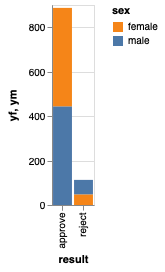

In [206]:
# Visualization using vega lite
from vega import VegaLite

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "transform":[
    {"calculate": "datum.class == 1 ? 'approve' : 'reject'", "as": "result"},
    {
      "aggregate": [
        {
          "op": "count",
          "as": "count_sex"
        }
      ],
      "groupby": [
        "sex",
        "result"
      ]
    },
    {"stack": "count_sex", "as": ["f", "m"], "groupby": ["result"]},
    {
      "window": [
        {
          "field": "sex",
          "op": "count",
          "as": "offset"
        }
      ],
      "groupby": ["result"],
      "frame": ["null", "null"]
    },  
    {"calculate": "datum.f-datum.offset/2", "as": "yf"},
    {"calculate": "datum.m-datum.offset/2", "as": "ym"}
  ],
  "mark": "bar",
  "encoding": {
    "x": {"type": 'nominal', "field": "result"},
#     "y": {"aggregate": "count", "field": "sex", "type": "quantitative"},
    "y": {"field": "yf","type": "quantitative"},
    "y2": {"field": "ym","type": "quantitative"},
    "color": {
        "field": "sex", 
        "type": "nominal",
        "scale": {"range": ["#F58518", "#4C78A8"]}
    },
  }
}, samples_rf)

In [192]:
# Viusalization using py_d3

%load_ext py_d3

%%d3
<style>

.bar {
  fill: steelblue;
}

.bar:hover {
  fill: brown;
}

.axis--x path {
  display: none;
}

</style>
<svg width="960" height="500"></svg>
<script>

var svg = d3.select("svg"),
    margin = {top: 20, right: 20, bottom: 30, left: 40},
    width = +svg.attr("width") - margin.left - margin.right,
    height = +svg.attr("height") - margin.top - margin.bottom;

var x = d3.scaleBand().rangeRound([0, width]).padding(0.1),
    y = d3.scaleLinear().rangeRound([height, 0]);

var g = svg.append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.tsv("../data/data.tsv", function(d) {
  d.frequency = +d.frequency;
  return d;
}, function(error, data) {
  if (error) throw error;

  x.domain(data.map(function(d) { return d.letter; }));
  y.domain([0, d3.max(data, function(d) { return d.frequency; })]);

  g.append("g")
      .attr("class", "axis axis--x")
      .attr("transform", "translate(0," + height + ")")
      .call(d3.axisBottom(x));

  g.append("g")
      .attr("class", "axis axis--y")
      .call(d3.axisLeft(y).ticks(10, "%"))
    .append("text")
      .attr("transform", "rotate(-90)")
      .attr("y", 6)
      .attr("dy", "0.71em")
      .attr("text-anchor", "end")
      .text("Frequency");

  g.selectAll(".bar")
    .data(data)
    .enter().append("rect")
      .attr("class", "bar")
      .attr("x", function(d) { return x(d.letter); })
      .attr("y", function(d) { return y(d.frequency); })
      .attr("width", x.bandwidth())
      .attr("height", function(d) { return height - y(d.frequency); });
});

</script>

SyntaxError: invalid syntax (<ipython-input-192-2714cf6d6aef>, line 6)

In [81]:
type('a')=='str'

False